In [11]:
#Graph dists
from graph_distances.competing_methods import getEVdist, getDegreedist, getG2V_dist, getGOT, getNodeEmbeddingdist
from our_external_pypi_package.prob_OT import getOT

#Graph generation
from tools.graph_generator import sample_uniform_csEP, sample_csEP, make_symmetric, sample_planted_role_model
from tools.graph_functions import permute_graph,swap_first_and_last,sort_by_node_degree,sort_by_EV

#Benchmark
from benchmark import knn
import time

#Plotting
from tools.plotting import plot_heatmap, hier_clustering, plot_emb
import seaborn as sns
import matplotlib.pyplot as plt

#External Packages
import networkx as nx
import numpy as np
import pandas as pd
import random

### Generate Synthetic Networks

In [12]:
def gen_networks(model,param_configs,n): 
    return [model(*params) for params in param_configs for _ in range(n) ]

n_networks = 20 #Number of networks for each class
n_nodes = (11,200) #Range of network sizes

erdos_renyi_params = [(n, 6/n) for n in np.random.choice(np.arange(*n_nodes), (n_networks,))]#,(n_nodes,0.11),(n_nodes,0.12)]
watts_strogatz_params = [(n,6,0.3) for n in np.random.choice(np.arange(*n_nodes), (n_networks,))]#,(n_nodes,11,0.11),(n_nodes,12,0.12)]
barabasi_albert_params = [(n,int(3)) for n in np.random.choice(np.arange(*n_nodes), (n_networks,))]#,(n_nodes,11),(n_nodes,12)]
#SBM_params = [([int(0.5*n),int(0.5*n)],np.array([[0.8,0.2],[0.2,0.8]]) * 2*6/n) for n in np.random.choice(np.arange(*n_nodes), (n_networks,))]
config_params = [([5]*(n//2)+[7]*(n//2),) for n in np.random.choice(np.arange(*n_nodes), (n_networks,))]

#RIP_params = [(5, [5]*5, make_symmetric(np.random.random((5,5)))) for n in range(n_networks)]
#RIP2_params = [(5, [5]*5, make_symmetric(np.random.random((5,5)))) for n in range(n_networks)]
Trials = gen_networks(nx.erdos_renyi_graph,erdos_renyi_params,1) + \
         gen_networks(nx.watts_strogatz_graph,watts_strogatz_params,1) + \
         gen_networks(nx.barabasi_albert_graph,barabasi_albert_params,1) + \
         gen_networks(lambda *x : nx.configuration_model(*x, create_using=nx.Graph),config_params,1)    
         #gen_networks(lambda x,y,z: nx.from_numpy_array(sample_planted_role_model(x,y,z)),RIP_params,1) + \
         #gen_networks(lambda x,y,z: nx.from_numpy_array(sample_planted_role_model(x,y,z)),RIP2_params,1)
Trials = [permute_graph(g) for g in Trials]
Trials = [nx.to_numpy_array(g) for g in Trials]

labels = [f"Erdos-Renyi" for i in range(len(erdos_renyi_params)) for _ in range(1)] + \
         [f"Watts-Strogatz" for i in range(len(watts_strogatz_params)) for _ in range(1)] + \
         [f"Barabási–Albert" for i in range(len(barabasi_albert_params)) for _ in range(1)] + \
         [f"Configuration" for i in range(len(config_params)) for _ in range(1)] #+ \
         #[f"RIP" for i in range(len(RIP_params)) for _ in range(1)] + \
         #[f"RIP2" for i in range(len(RIP2_params)) for _ in range(1)]

### Set Parameters for CNP and CCB

In [13]:
#Params for CNP and CBB
i = 1000 #i instantiations: the number of sampled colorings
k = 10 #k colors: the number of different colors randomily assigned to nodes
d = 5 #d depth: the number of steps A^d from each node

#Number of threads for parallel processing (when supported by method)
n_cpus = 10

#This will include GOT, Role2Vec, Node2Vec and the Covariance-based CNP & CCB OT for the comparison but increases runtime of benchmark significantly!
include_slow_methods = True
slow_methods = ["Role2vec-GW","Node2vec-GW","GOT","CNP-ScaledW","CCB-ScaledW","CNP-FullW","CCB-FullW"]

### Setup all methods for comparison

In [14]:
path = "../data/results/" 
name = "SyntheticNetworks_Computed"
precomputed_dists,plans,times = {},{},{}
if True:
    precomputed_dists =  np.load(path+name+"Dists.npy",allow_pickle=True).tolist()
    #np.save(path+name+"plans.npy",plans) 
    times = np.load(path+name+"Times.npy",allow_pickle=True).tolist()

methods =  {
    #Euclidean Dists
    "Degree": (lambda G1,G2: getDegreedist(G1,G2)),
    "EV": (lambda G1,G2: getEVdist(G1,G2)),
    "Graph2Vec": (lambda G1,G2: getG2V_dist(G1,dim=(64 * k * d))),
    
    #Gromov-Wasserstein Dists
    "Role2vec-GW_parallel":(lambda G1,G2: getOT(G1,G2, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1,num_workers=n_cpus,embedding_method="role2vec",distance='gw')),
    "Role2vec-GW":(lambda G1,G2: getNodeEmbeddingdist(G1, G2, embedding_name='role2vec', D_dimensions=(k * d),distance='gw')),

    
    "Node2Vec-GW_parallel":(lambda G1,G2: getOT(G1,G2, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1,num_workers=n_cpus,embedding_method="node2vec",distance='gw')),
    "Node2Vec-GW":(lambda G1,G2: getNodeEmbeddingdist(G1, G2, embedding_name='node2vec', D_dimensions=(k * d),distance='gw')),
    
    #Wasserstein Dists.
    #"GOT": (lambda G1,G2: getGOT(G1,G2,dist='GOT')),

    "CNP-TiedW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None )),
    "CCB-TiedW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None )),
    
    "CNP-ScaledW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None,covariance='scaled')), 
    "CCB-ScaledW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None,covariance='scaled')),

    "CNP-FullW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None,covariance='full')), 
    "CCB-FullW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None,covariance='full')),    
    }

#Filter out slow methods if not selected for comparison
methods = {m: methods[m] for m in methods.keys() if (m not in slow_methods or include_slow_methods)}

### Compute all pairwise graph distances with the respective methods

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


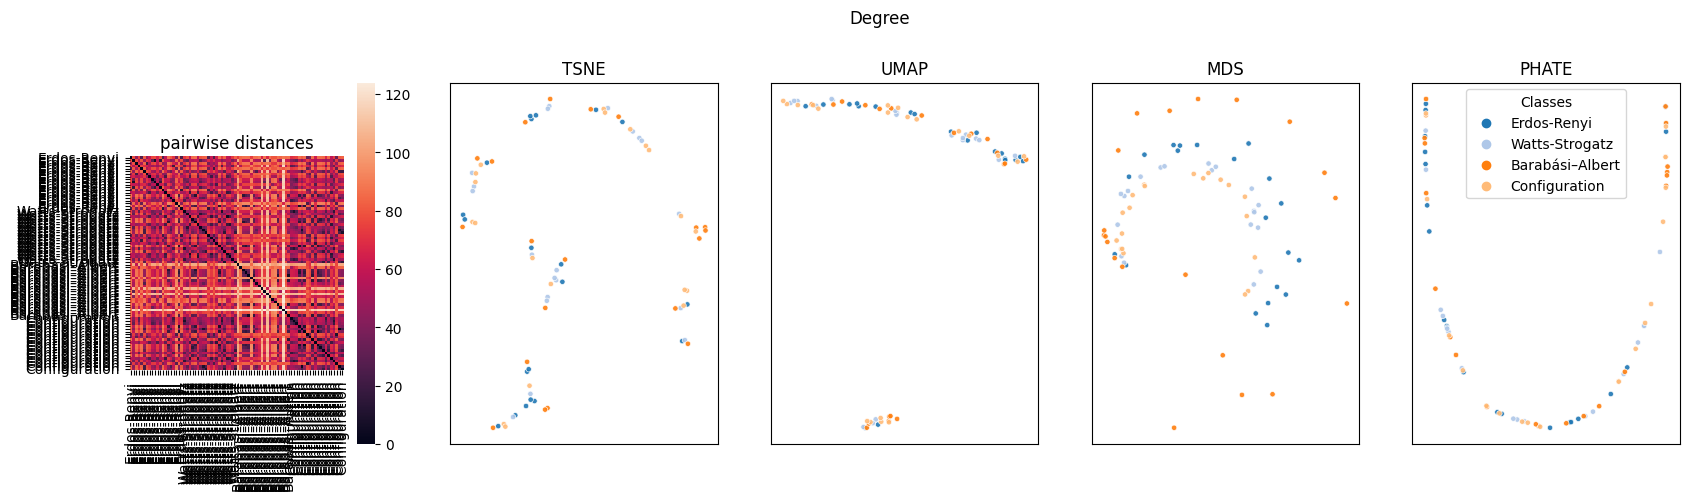

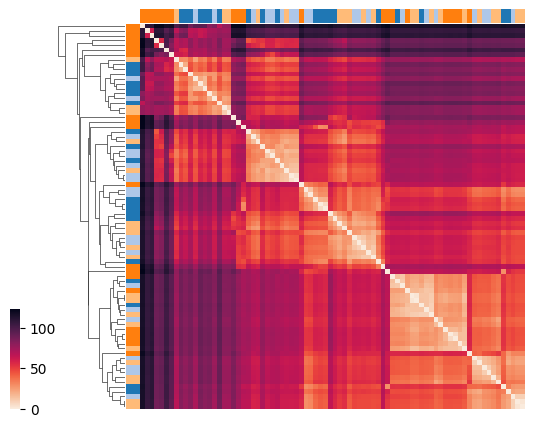

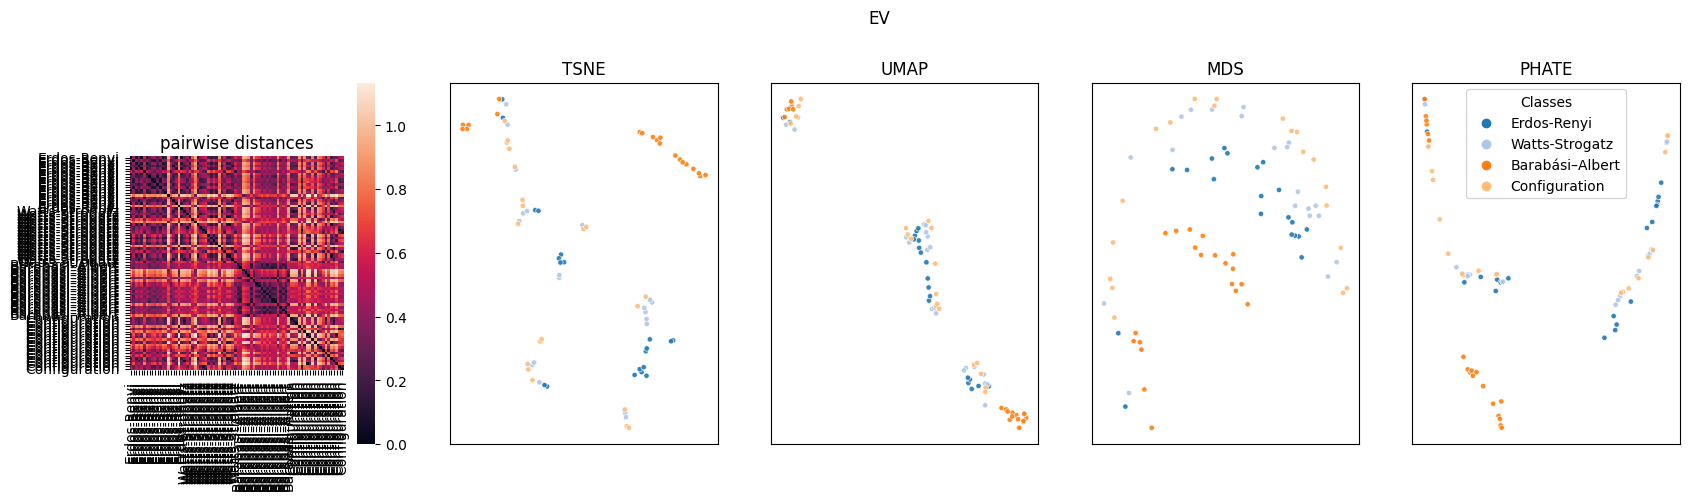

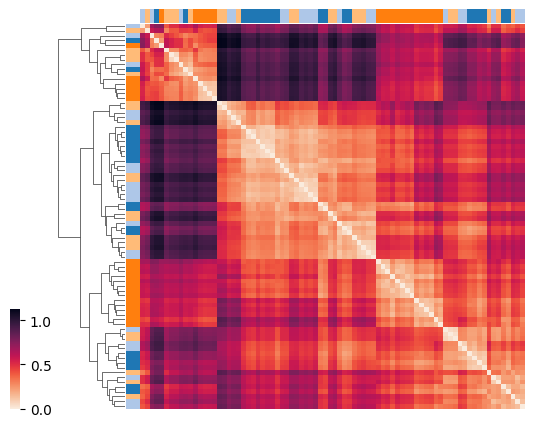

100%|██████████| 80/80 [00:00<00:00, 3800.57it/s]


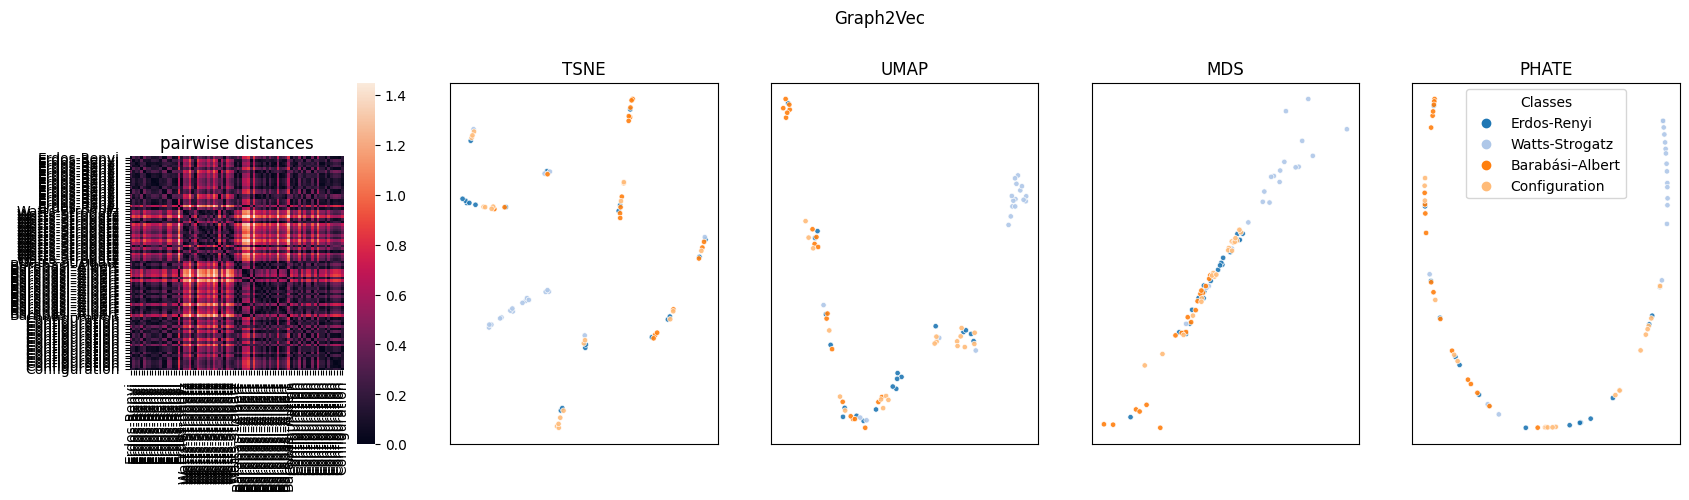

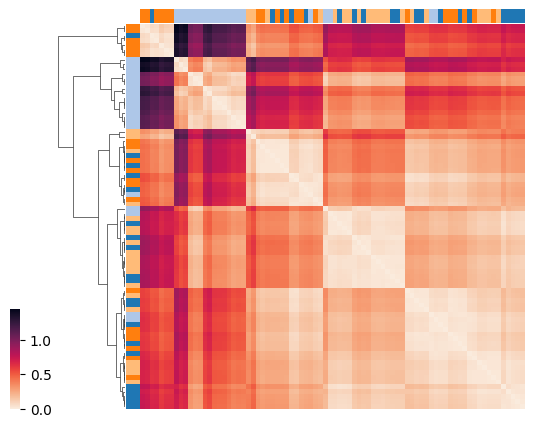

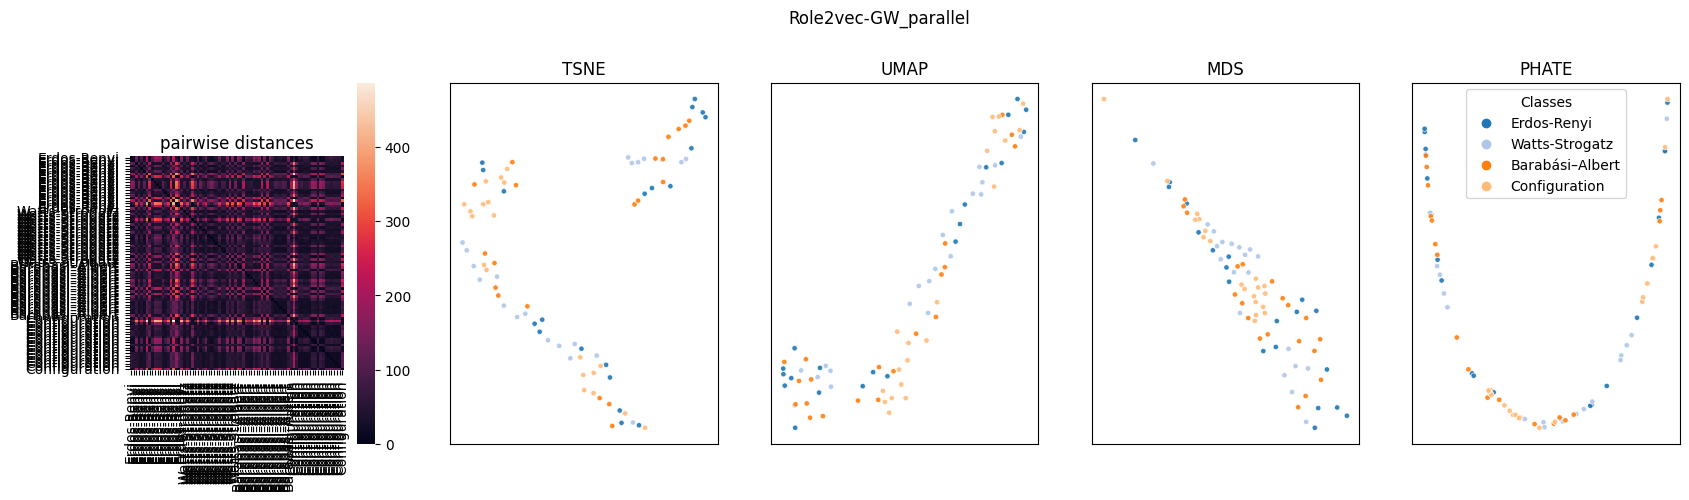

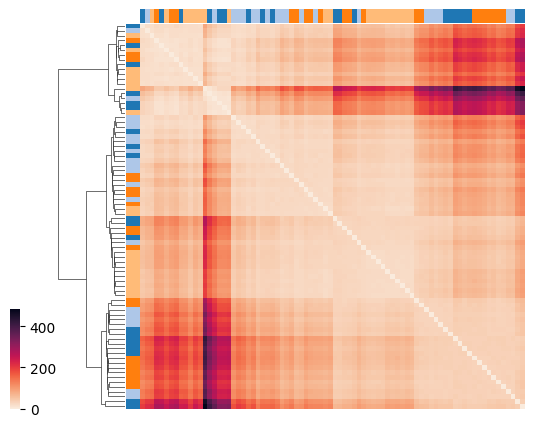

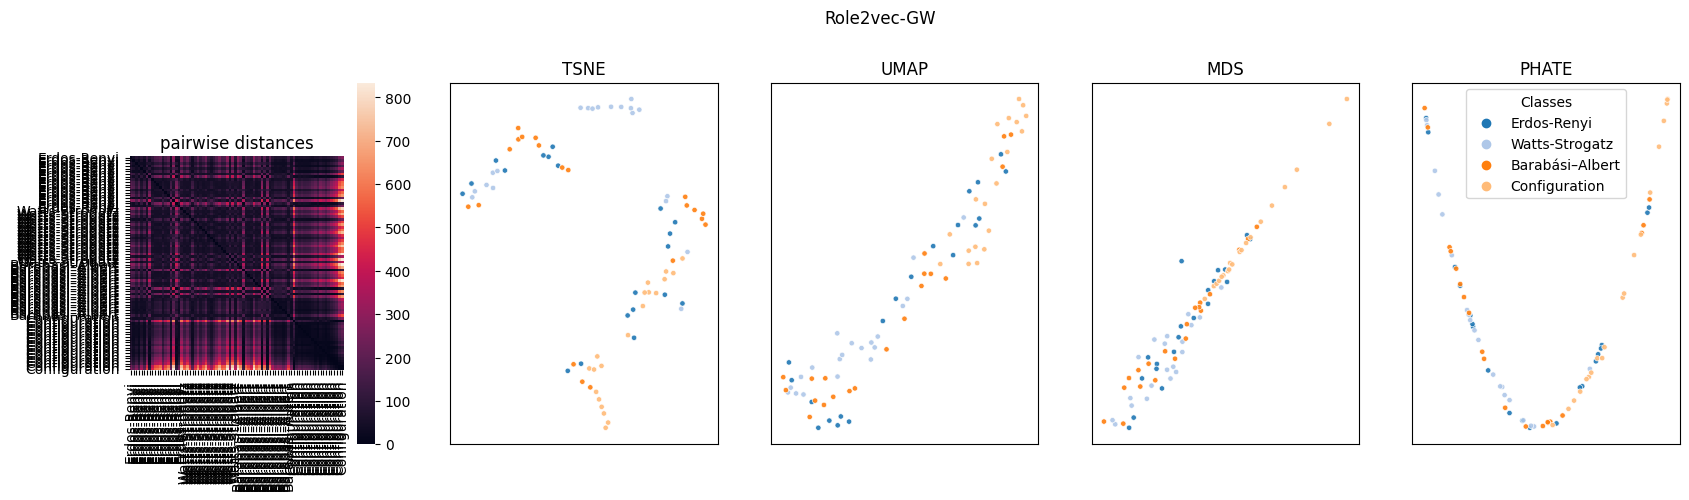

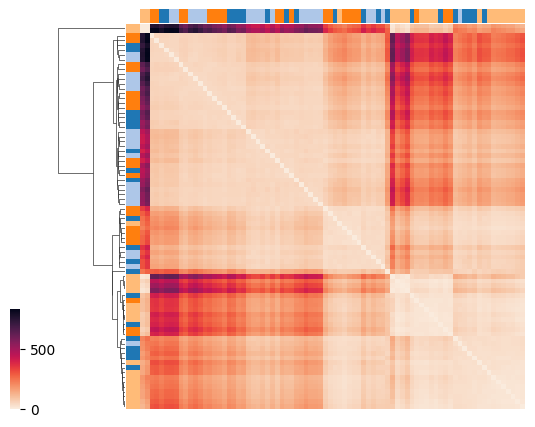

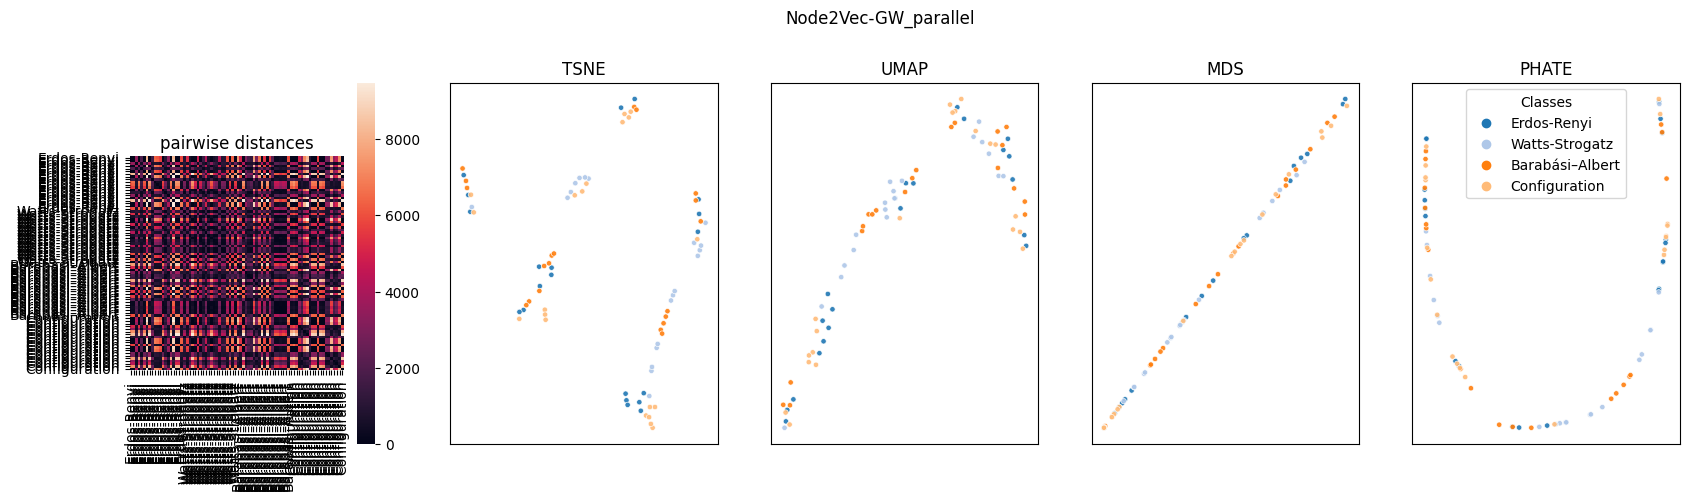

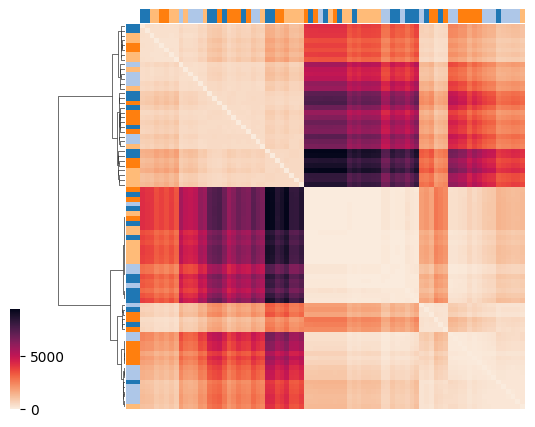

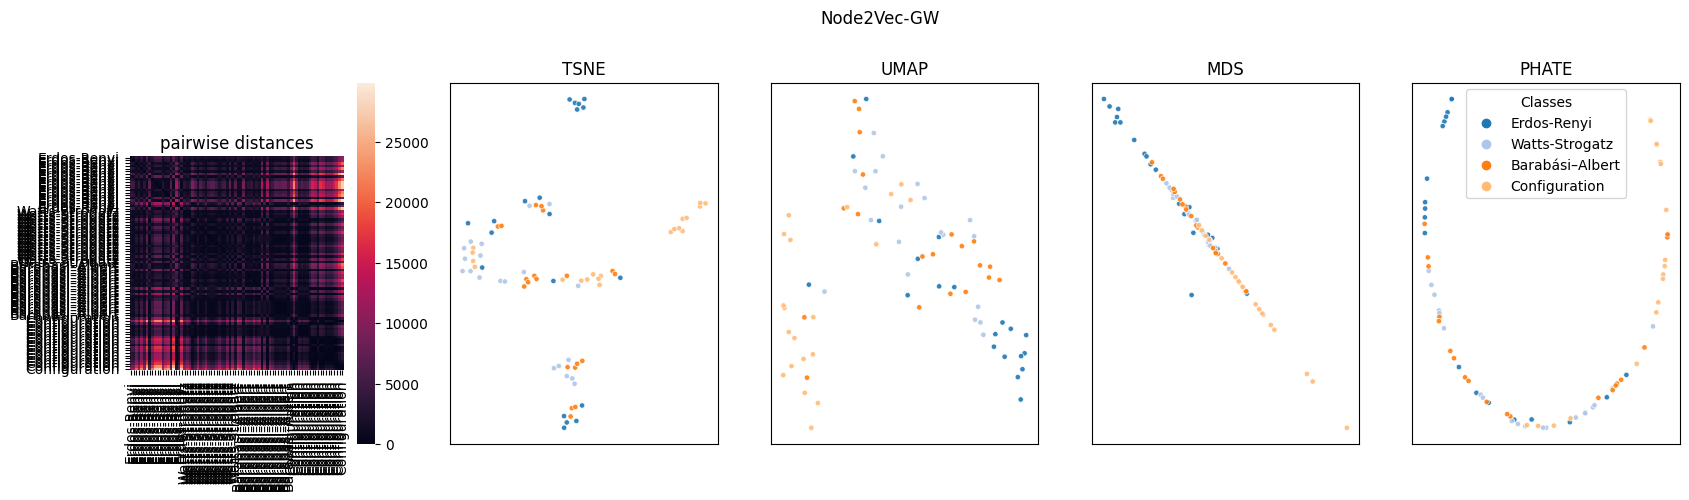

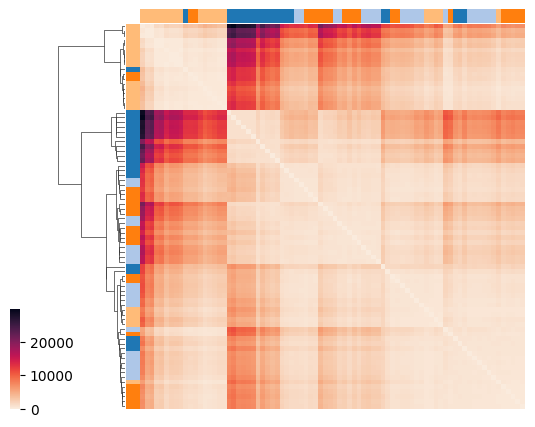

DONE: 100%|██████████| 3240/3240 [00:14<00:00, 227.91it/s] 


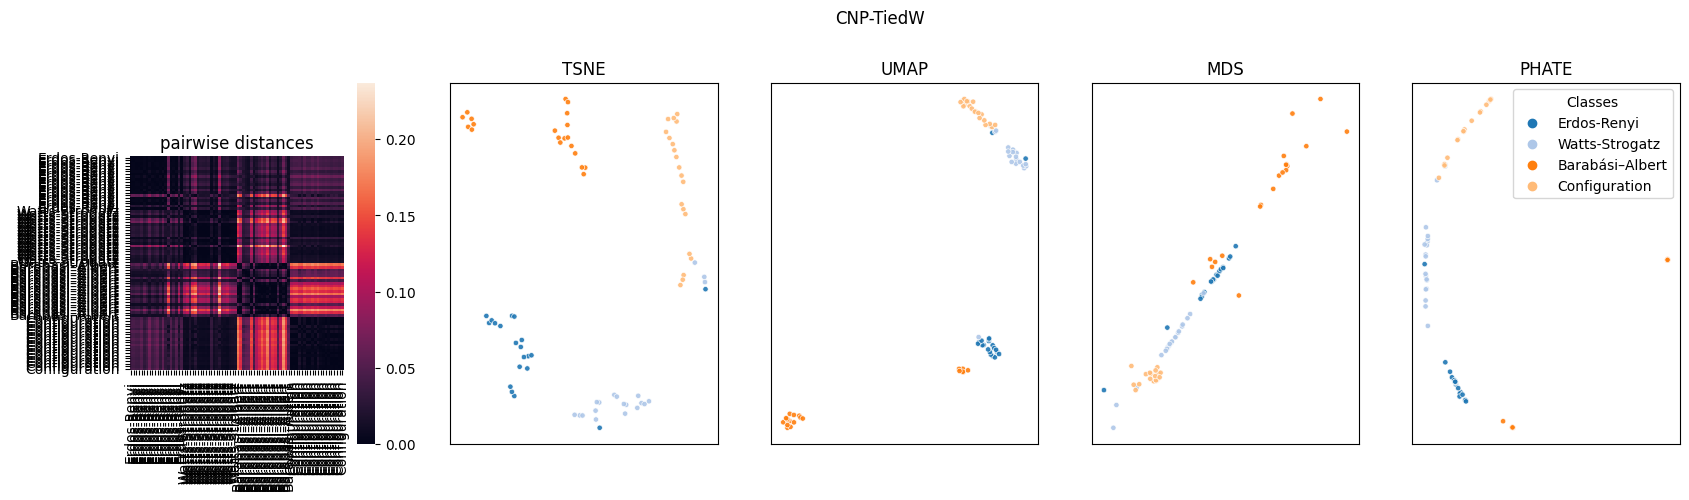

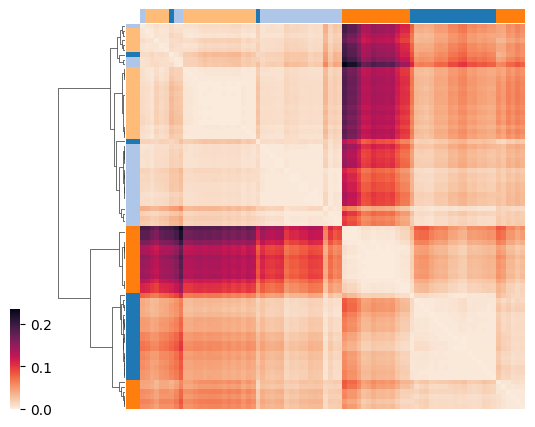

DONE: 100%|██████████| 3240/3240 [00:14<00:00, 228.29it/s] 


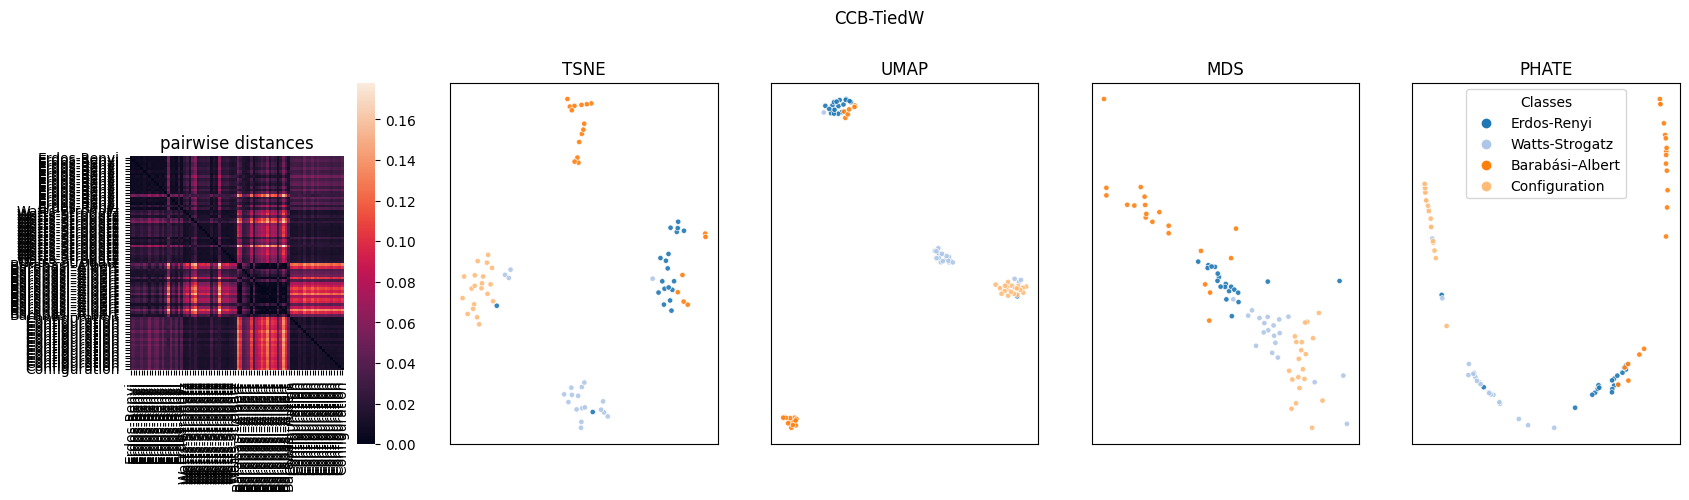

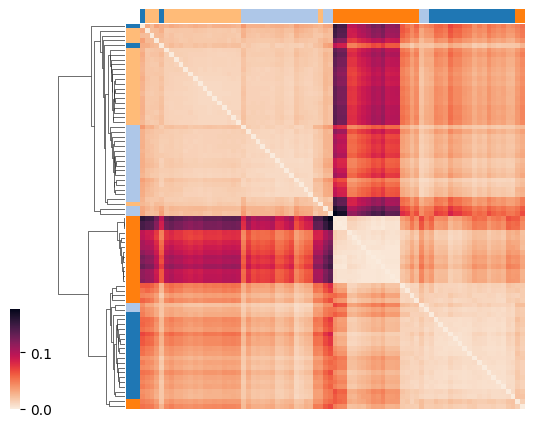

/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/graphtools/graphs.py:1038: RuntimeWarning: divide by zero encountered in divide
  pdx = (pdx.T / bandwidth).T
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/graphtools/graphs.py:1038: RuntimeWarning: invalid value encountered in divide
  pdx = (pdx.T / bandwidth).T


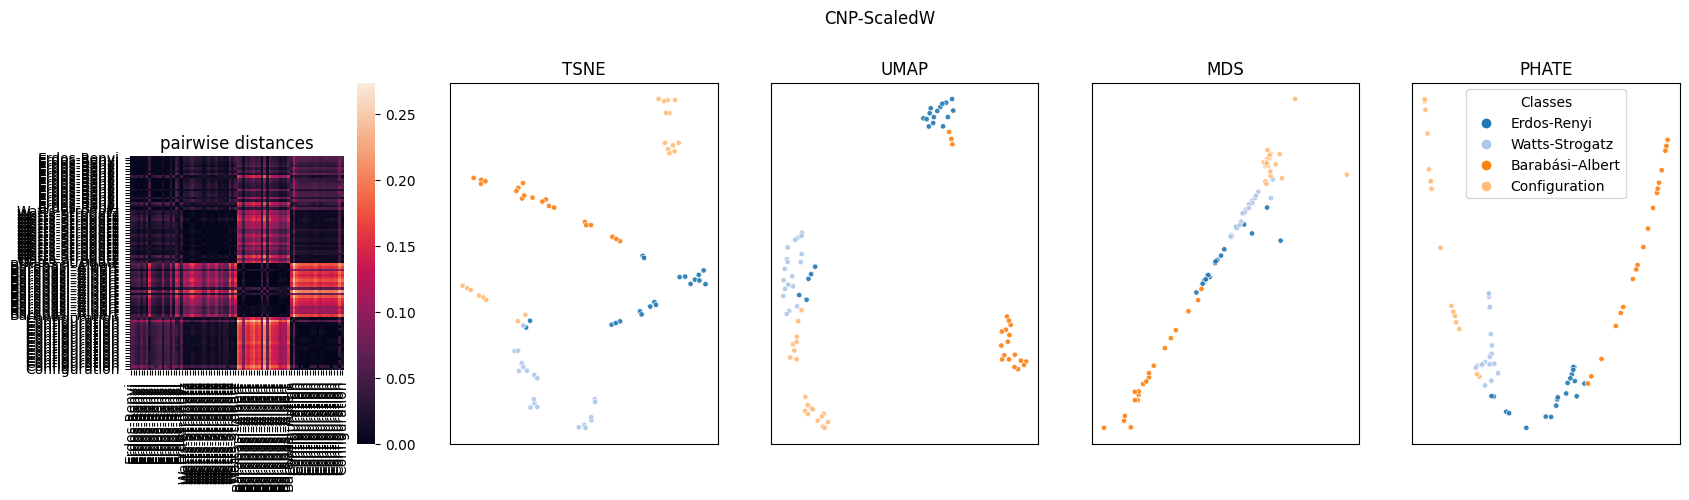

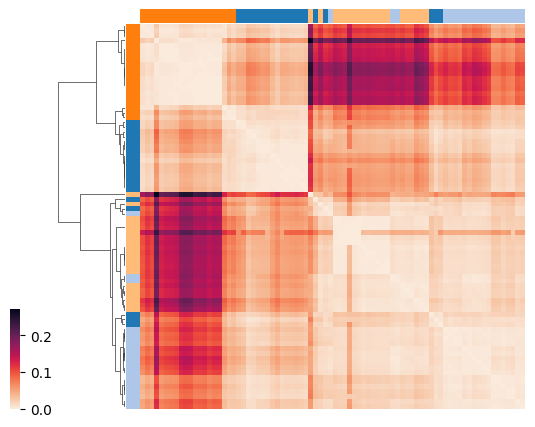

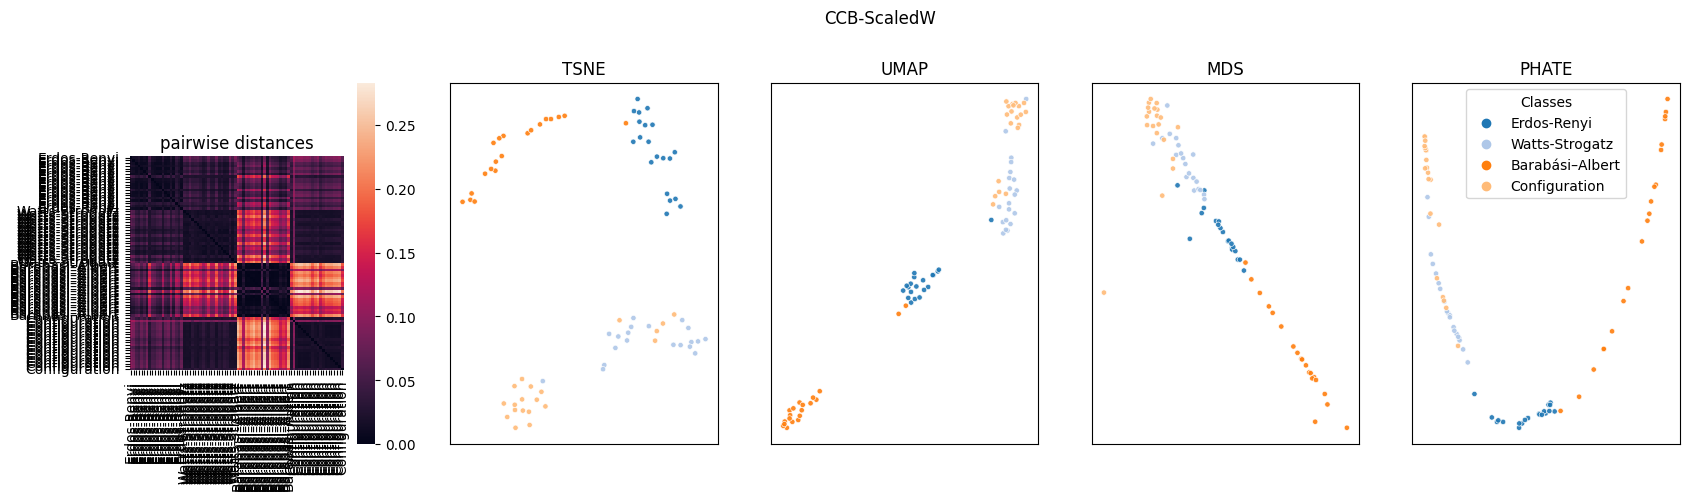

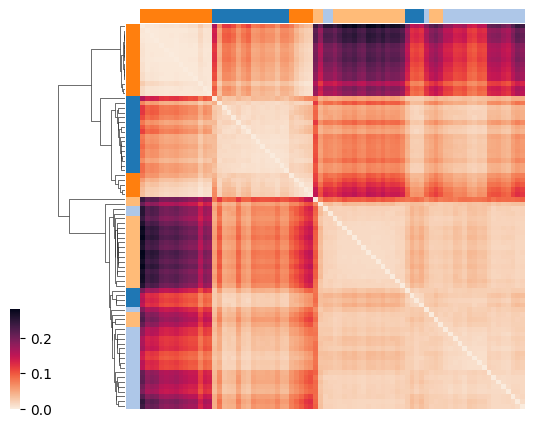

DONE:   0%|          | 0/3240 [00:00<?, ?it/s]/home/kuehn/CNP_OT_clean/cnp-ot/code/our_external_pypi_package/prob_OT.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[x,y]+= np.trace(GMM1['cov'][x]+GMM2['cov'][y]-2*Sigma010)
/home/kuehn/CNP_OT_clean/cnp-ot/code/our_external_pypi_package/prob_OT.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[x,y]+= np.trace(GMM1['cov'][x]+GMM2['cov'][y]-2*Sigma010)
/home/kuehn/CNP_OT_clean/cnp-ot/code/our_external_pypi_package/prob_OT.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[x,y]+= np.trace(GMM1['cov'][x]+GMM2['cov'][y]-2*Sigma010)
/home/kuehn/CNP_OT_clean/cnp-ot/code/our_external_pypi_package/prob_OT.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[x,y]+= np.trace(GMM1['cov'][x]+GMM2['cov'][y]-2*Sigma010)
/home/kuehn/CNP_OT_clean/cnp-ot/code/our_external_pypi_package/prob_OT.py:59: Comp

In [15]:
%load_ext autoreload
%autoreload 2

#Precompute Distances
time_limit = 60
for method, func in methods.items():
    if times.get(method, 0) < time_limit:
        st = time.time()
        precomputed_dists[method], plans[method], _ , _ = func(Trials.copy(),None)
        et = time.time()
        times[method] = et - st
        precomputed_dists[method][precomputed_dists[method]<0] = 0

    fig, axs = plt.subplots(1,5,figsize=(20,5))
    plot_heatmap(precomputed_dists[method],labels,ax=axs[0])
    plot_emb(precomputed_dists[method],method='tsne',colors=labels,ax=axs[1],legend=False,title="TSNE")
    plot_emb(precomputed_dists[method],method='umap',colors=labels,ax=axs[2],legend=False,title="UMAP")
    plot_emb(precomputed_dists[method],method='mds',colors=labels,ax=axs[3],legend=False,title="MDS")
    plot_emb(precomputed_dists[method],method='phate',colors=labels,ax=axs[4],legend=True,title="PHATE")
    fig.suptitle(method)
   
    hier_clustering(precomputed_dists[method],labels, ax=None)
    plt.show()
    


### Save computed distances

In [ ]:
path = "../data/results/" 
name = "SyntheticNetworks_Computed"

if True:
    np.save(path+name+"Dists.npy",precomputed_dists)
    np.save(path+name+"Times.npy",times)

### Weighted KNN over precomputed distances to benchmark competing methods

,KNN T=0.9,SC,ARI,Time
method,,,,
Degree,0.44±0.11,-.074,0.08±0.00,0.00
EV,0.68±0.10,.041,0.38±0.00,0.07
Graph2Vec,0.42±0.07,-.008,0.17±0.00,0.12
Role2vec-GW_parallel,0.44±0.11,-.144,0.07±0.00,217.07
Role2vec-GW,0.68±0.11,.033,0.37±0.00,156.11
Node2Vec-GW_parallel,0.55±0.12,-.149,0.21±0.00,139.85
Node2Vec-GW,0.59±0.08,.032,0.26±0.00,297.04
CNP-TiedW,0.96±0.04,.524,0.89±0.00,16.68
CCB-TiedW,0.93±0.06,.327,0.82±0.00,16.80


\begin{tabular}{lllll}
\toprule
 & KNN T=0.9 & SC & ARI & Time \\
method &  &  &  &  \\
\midrule
Degree & 0.44±0.11 & -.074 & 0.08±0.00 &  0.00 \\
EV & 0.68±0.10 & .041 & 0.38±0.00 &  0.07 \\
Graph2Vec & 0.42±0.07 & -.008 & 0.17±0.00 &  0.12 \\
Role2vec-GW_parallel & 0.44±0.11 & -.144 & 0.07±0.00 &  217.07 \\
Role2vec-GW & 0.68±0.11 & .033 & 0.37±0.00 &  156.11 \\
Node2Vec-GW_parallel & 0.55±0.12 & -.149 & 0.21±0.00 &  139.85 \\
Node2Vec-GW & 0.59±0.08 & .032 & 0.26±0.00 &  297.04 \\
CNP-TiedW & 0.96±0.04 & .524 & 0.89±0.00 &  16.68 \\
CCB-TiedW & 0.93±0.06 & .327 & 0.82±0.00 &  16.80 \\
CNP-ScaledW & 0.96±0.04 & .457 & 0.89±0.00 &  120.75 \\
CCB-ScaledW & 0.87±0.08 & .361 & 0.70±0.00 &  126.95 \\
\bottomrule
\end{tabular}



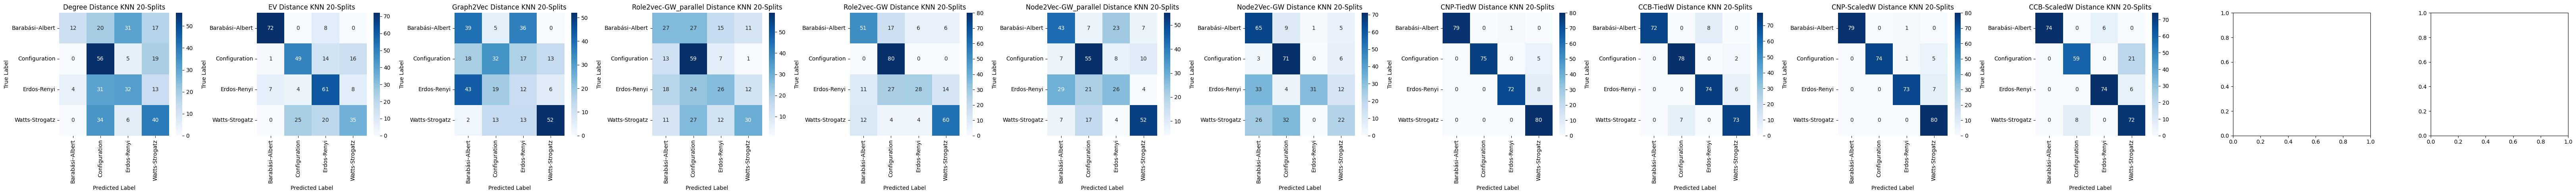

In [ ]:
fig, axs = plt.subplots(1,len(methods.keys()),figsize=(len(methods.keys())*5,5),squeeze=False)
results = {"method":[],
           "KNN T=0.9":[],
           "SC":[],
           "ARI":[],
           "Time":[]}

for m, (method, dist) in enumerate(precomputed_dists.items()):
    pred, true, score, ari = knn.from_dists(Trials,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.2,n_splits=20,n_neighbors=5)
    knn.plot_1split(np.concatenate(pred),np.concatenate(true),title=f"{method} Distance KNN {len(pred)}-Splits",ax=axs[0,m])
    sil = knn.silhouette_score_wrapper(precomputed_dists[method],labels)

    results["method"].append(method)
    results["KNN T=0.9"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")
    results["ARI"].append(f"{np.average(ari):.2f}±{np.std(ari):.2f}")
    results["SC"].append(("%.3f" % sil).replace("-0","-").lstrip("0")) 
    results["Time"].append(f"{times[method]/(len(Trials)*(len(Trials)-1)/2) * 1000: .2f}")

fig.tight_layout()
knn.plot_table(pd.DataFrame(results))